# Imports y Tipos

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

from functools import reduce

import json

from h3 import h3

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, lit, to_date, when, array
from pyspark.sql import functions as F
from pyspark.sql.types import LongType, StringType, StructField, StructType, ArrayType, IntegerType
from h3_pyspark.indexing import index_shape
import h3_pyspark
from pyspark.sql.window import Window

from datetime import timedelta, date

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from math import ceil, floor

spark = SparkSession.builder \
                .config("spark.jars", "./utils/postgresql-42.5.1.jar") \
                .master("local[40]") \
                .config("spark.driver.memory", "50g") \
                .config("spark.executor.memory", "50g") \
                .appName("Generacion de Redes") \
                .getOrCreate()


23/02/23 18:12:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
SparkDataFrame = pyspark.sql.dataframe.DataFrame

# Carga de Datos

In [3]:
DAY = "01"
MONTH = "12"
YEAR = "2020"

Los datos de movilidad `(MOVILIDAD_RAW)` consiste de una colección de pings anonimizados que se obtienen a partir de dispositivos de individuos y sirven para estimar la posición de este último.

Consideraciones:
- Sólo se toman registros cuya precisión horizontal (`horizontal_accuracy`) sea mayor o igual a 100

In [4]:
MOVILIDAD_RAW = spark.read.option("header", True).parquet(f'{os.environ[f"MOVILIDAD_RAW_{YEAR}"]}/month={MONTH}/day={DAY}') \
    .distinct() \
    .where(col("horizontal_accuracy") >= lit(100.0)) \
    .withColumn("utc_datetime", F.from_unixtime(col("utc_timestamp"))) \
    .withColumn("cdmx_datetime", F.from_utc_timestamp(col("utc_datetime"), "America/Mexico_City")) \
    .select("utc_timestamp", "cdmx_datetime", "caid", "latitude", "longitude", "horizontal_accuracy")

In [5]:
MOVILIDAD_RAW.printSchema()
MOVILIDAD_RAW.show(5)

root
 |-- utc_timestamp: long (nullable = true)
 |-- cdmx_datetime: timestamp (nullable = true)
 |-- caid: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- horizontal_accuracy: double (nullable = true)



+-------------+-------------------+--------------------+---------+-----------+-------------------+
|utc_timestamp|      cdmx_datetime|                caid| latitude|  longitude|horizontal_accuracy|
+-------------+-------------------+--------------------+---------+-----------+-------------------+
|   1606869915|2020-12-01 18:45:15|a3828812812f14feb...|19.451782| -99.131968|              499.0|
|   1606870525|2020-12-01 18:55:25|376df0b6b1107c827...|19.503551| -99.249922|              397.0|
|   1606874313|2020-12-01 19:58:33|c551c338d0d9d56f7...|16.223419| -97.267082|              137.6|
|   1606855109|2020-12-01 14:38:29|8857115751e523e3f...|20.562797|-103.462024|              115.8|
|   1606843886|2020-12-01 11:31:26|4736962bdedce1e4c...|19.350971| -99.026819|              121.4|
+-------------+-------------------+--------------------+---------+-----------+-------------------+
only showing top 5 rows



In [6]:
MOVILIDAD_RAW.count()

1329372

El catálogo de AGEB's (`AGEBS_VM`) fue obtenido a partir de los [datos que provee el INEGI]() de estas últimas. De todos los campos que posee resaltan:
- `cve_geo`: Un identificador de cada una de las AGEBs
- `geometry`: Definición en formato Json del polígono que delimita el área de AGEB

Únicamente contiene AGEBS que se consolidan dentro del área del Valle de México. Abarca los agebs de CDMX, Edo. de México y algunas partes de Hidalgo

In [7]:
zonas_metropolitanas_2015 = spark.read.option("header", True).csv("./raw_data/zonas_metropolitanas_2015.csv")
zonasMetropolitanas_vm = zonas_metropolitanas_2015.where(col("CVE_ZM") == lit("09.01"))
all_agebs = spark.read.parquet("./raw_data/utils/ageb_catalog/")

AGEBS_VM = zonas_metropolitanas_2015.join(all_agebs
        , zonas_metropolitanas_2015.NOM_MUN == all_agebs.nom_agem
        , how="left") \
    .where(
        (col("cve_agee") == lit("09")) | (col("cve_agee") == lit("13")) | (col("cve_agee") == lit("15"))
    ) \
    .select("cve_geo", "cve_agee", "cve_agem", "cve_loc", "cve_ageb"
    , "nom_agee", "nom_agem", "geometry", "type", col("CVE_ENT").alias("cve_ent"))

In [8]:
AGEBS_VM.printSchema()
AGEBS_VM.show(5)

root
 |-- cve_geo: string (nullable = true)
 |-- cve_agee: string (nullable = true)
 |-- cve_agem: string (nullable = true)
 |-- cve_loc: string (nullable = true)
 |-- cve_ageb: string (nullable = true)
 |-- nom_agee: string (nullable = true)
 |-- nom_agem: string (nullable = true)
 |-- geometry: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cve_ent: string (nullable = true)

+-------------+--------+--------+-------+--------+----------------+----------+--------------------+------+-------+
|      cve_geo|cve_agee|cve_agem|cve_loc|cve_ageb|        nom_agee|  nom_agem|            geometry|  type|cve_ent|
+-------------+--------+--------+-------+--------+----------------+----------+--------------------+------+-------+
|150120001007A|      15|     012|   0001|    007A|          México|  Atizapán|{"type": "MultiPo...|urbana|     15|
|1510600010307|      15|     106|   0001|    0307|          México|    Toluca|{"type": "MultiPo...|urbana|     15|
|1505400491186|      15|  

# Obtención de NTL

Un Nightime Location (NTL) hace referencia al lugar estimado en el que habita una persona. Se obtiene a partir del monitoreo de sus pings dentro de la ventana de tiempo 10pm - 6am.

In [9]:
def single_ntl(movilidad_df: SparkDataFrame, ageb_df: SparkDataFrame) -> SparkDataFrame:
    """ Función encargada de obtener la colección de NTL ganadores por día de actividad
    movilidad_df (SparkDataFrame) : Un data frame de Spark con el registro de actividad en el día d
    ageb_df (SparkDataFrame) : Catálogo de AGEBS, debe de contener el shape ("geometry") de cada AGEB
    """

    # Se filtran los pings para obtener aquellos dentro de la ventana 10pm - 6am
    filtered_df = movilidad_df.where(
        (F.hour(col("cdmx_datetime")) >= 22) | (F.hour(col("cdmx_datetime")) < 6)
    )

    # Se localizan los pings dentro de su correspondiente AGEB
    indexed_df = filtered_df.withColumn("h3index_5", h3_pyspark.geo_to_h3("latitude", "longitude", lit(5))) \
        .withColumn("h3index_12", h3_pyspark.geo_to_h3("latitude", "longitude", lit(12))) \
        .withColumn("h3index_15", h3_pyspark.geo_to_h3("latitude", "longitude", lit(15)))

    agebs_indexed = ageb_df.select("cve_geo", "geometry") \
        .withColumn("h3polyfill_5", index_shape("geometry", lit(5))) \
        .withColumn("h3polyfill_5", F.explode("h3polyfill_5")) \
        .withColumn("h3polyfill_12", index_shape("geometry", lit(12))) \
        .withColumn("h3polyfill_12", F.explode("h3polyfill_12"))
    
    located_df = indexed_df.join(agebs_indexed
            , indexed_df.h3index_5 == agebs_indexed.h3polyfill_5
            , how="left") \
        .where(
            (col("h3index_12") == col("h3polyfill_12"))
        ) \
        .select("utc_timestamp", "cdmx_datetime", "caid", "h3index_15", "cve_geo")

    # Se agrupan los distintos pings existentes en ventanas de 10 minutos
    clustered_df = located_df.withColumn("time_window", F.window("cdmx_datetime", "600 seconds"))

    # Se calcula el número de clusters por AGEB que posee cada dispositivo
    scored_df = clustered_df.groupBy("caid", "cve_geo") \
        .agg(F.count("time_window").alias("score"))

    # El ageb con mayor número de clusters registrados es denominado como ganador para ese día
    w = Window().partitionBy("caid").orderBy(col("score").desc())
    winners_df = scored_df.withColumn("rank", F.row_number().over(w)) \
        .where(col("rank") == 1) \
        .select("caid", "cve_geo", "score")

    return winners_df


Para calcular el NTL de un individuo es necesario revisar su actividad de los 15 días anteriores. En caso de no contarse con algún NTL candidato se asigna el AGEB ficticio "0000000000000"

In [10]:
def last_n_days_ntl(day: int, month: int, year: int, days_offset: int) -> SparkDataFrame :

    # Se calcula la ventana de tiempo correspondiente a days_offset atrás
    curr_day = date(year, month, day)
    print(curr_day)
    n_days_ago = timedelta(days=days_offset)
    print(n_days_ago)
    d0 = curr_day - n_days_ago
    dn = curr_day - timedelta(days=1)
    print(d0, dn)

    date_range = [d0 + timedelta(days=x) for x in range(0, days_offset)]
    
    schema = StructType([
        StructField('caid', StringType(), True),
        StructField('cve_geo', StringType(), True),
        StructField('score', IntegerType(), True)
    ])

    emptyRDD = spark.sparkContext.emptyRDD()
    emptyDF = spark.createDataFrame(emptyRDD,schema)

    df_acc = emptyDF

    for d in date_range:

        curr_df = spark.read.option("header", True).parquet(f'{os.environ[f"MOVILIDAD_RAW_{d.year}"]}/month={str(d.month).zfill(2)}/day={str(d.day).zfill(2)}') \
            .distinct() \
            .where(col("horizontal_accuracy") >= lit(100.0)) \
            .withColumn("utc_datetime", F.from_unixtime(col("utc_timestamp"))) \
            .withColumn("cdmx_datetime", F.from_utc_timestamp(col("utc_datetime"), "America/Mexico_City")) \
            .select("utc_timestamp", "cdmx_datetime", "caid", "latitude", "longitude", "horizontal_accuracy")
    
        curr_ntl = single_ntl(curr_df, AGEBS_VM)

        df_acc = df_acc.union(curr_ntl)

    last_n_days_candidates = df_acc.groupBy("caid", "cve_geo").count()

    # TODO: Revisar que sean únicos las ntl
    w = Window().partitionBy("caid").orderBy(col("count").desc())
    ntl_df = last_n_days_candidates.withColumn("rank", F.row_number().over(w)) \
        .where(col("rank") == 1) \
        .select("caid", "cve_geo")

    return ntl_df

In [11]:
home_agebs_catalog = last_n_days_ntl(1, 12, 2020, 15)

2020-12-01
15 days, 0:00:00
2020-11-16 2020-11-30


Se obtiene la tabla de pings agregando el ntl estimado

In [12]:
pings_table_pre = MOVILIDAD_RAW.join(home_agebs_catalog
                , MOVILIDAD_RAW.caid == home_agebs_catalog.caid
                , how="left") \
    .withColumn("h3index_5", h3_pyspark.geo_to_h3("latitude", "longitude", lit(5))) \
    .withColumn("h3index_12", h3_pyspark.geo_to_h3("latitude", "longitude", lit(12))) \
    .withColumn("h3index_15", h3_pyspark.geo_to_h3("latitude", "longitude", lit(15))) \
    .withColumn("home_ageb", F.when(~F.isnull(col("cve_geo")), col("cve_geo")).otherwise(lit("0000000000000"))) \
    .withColumn("time_window", F.window("cdmx_datetime", "600 seconds")) \
    .select("utc_timestamp", "cdmx_datetime", MOVILIDAD_RAW.caid, "home_ageb", "h3index_5", "h3index_12", "h3index_15", "time_window")

In [13]:
pings_table_pre.count()

1329372

In [14]:
getting_ageb_df = AGEBS_VM.select("cve_geo", "geometry") \
    .withColumn("h3polyfill_5", index_shape("geometry", lit(5))) \
    .withColumn("h3polyfill_5", F.explode("h3polyfill_5")) \
    .withColumn("h3polyfill_12", index_shape("geometry", lit(12))) \
    .withColumn("h3polyfill_12", F.explode("h3polyfill_12"))

pings_table = pings_table_pre.join(getting_ageb_df
        , pings_table_pre.h3index_5 == getting_ageb_df.h3polyfill_5
        , how="left") \
    .where(
        (col("h3index_12") == col("h3polyfill_12")) 
    ) \
    .select("time_window", "caid", "home_ageb"
        , col("cve_geo").alias("curr_geo"), "h3index_15") \
    .distinct()

#.where(
#    (col("home_ageb").isin(["0900200010203", "0900200010222", "0900200010294", "0900200010472", "0900200010542", "0900200010580", "0900200010754", "0900200010769"]))
#) \

A partir del cálculo de los NTL se obtiene una tabla que representa la posición de un individuo en distintas ventanas de tiempo distribuidas a lo largo del día así como el lugar donde vive aproximadamente:

In [15]:
pings_table.persist().show(10)
print(f"No. Regs: {pings_table.count()}")
print(f"No. Caids distintos: {pings_table.select('caid').distinct().count()}")
print(f"No. AGEBs distintas: {pings_table.select('home_ageb').distinct().count()}")

+--------------------+--------------------+-------------+-------------+---------------+
|         time_window|                caid|    home_ageb|     curr_geo|     h3index_15|
+--------------------+--------------------+-------------+-------------+---------------+
|{2020-12-01 13:20...|6ffb99347f07430e4...|0000000000000|1511800590416|8f4986722481314|
|{2020-12-01 13:20...|30961309212cfe0dc...|1508100190109|1508100190109|8f499506c7532cc|
|{2020-12-01 11:30...|ab994f9885b29d185...|0000000000000|1509900010828|8f499510b2d0512|
|{2020-12-01 07:00...|e2068a2f4be1c129b...|1503300011059|1501000010253|8f499527419d715|
|{2020-12-01 06:40...|09ba7ad3d8911f557...|0901300010654|0901300010654|8f499582ba50829|
|{2020-12-01 19:00...|eb0723abca1bb3174...|0000000000000|0900800010118|8f499584dbb649b|
|{2020-12-01 14:00...|0cf2403f15743d599...|0000000000000|0901600011090|8f4995b12504ccc|
|{2020-12-01 15:40...|9b90eeb4c9d2cc3f6...|0000000000000|0901500011500|8f4995bb52e922b|
|{2020-12-01 17:40...|beef989b73

No. Regs: 247060


No. Caids distintos: 46120


No. AGEBs distintas: 5538


In [16]:
#pings_table = pings_table.where((col("home_ageb") == lit("0900200010114")) | (col("home_ageb") == lit("0900200010133")) | (col("home_ageb") == lit("0900200010203")) | (col("home_ageb") == lit("0000000000000")) )
#pings_table.count()

# Cálculo de interacciones

Para realizar el cálculo de interacciones entre individuos se busca relacionar todos aquellos registros que indican una interacción sobre la misma baldosa (H3 res. 15) en el mismo intervalo de tiempo (10 mins.) sin contar las **autointeracciones**, eliminando **duplicados debidos a múltiples contactos** y **sin eliminar los duplicados espejo** (.i.e., si a,b entonces se elimina b,a)

In [17]:
interactions_base = pings_table.alias("a").join(pings_table.alias("b")
        , (col("a.h3index_15") == col("b.h3index_15")) & (col("a.time_window") == col("b.time_window"))
        , how="inner"
    ) \
    .where(col("a.caid") != col("b.caid")) \
    .select(col("a.caid").alias("caid_a"), col("a.home_ageb").alias("home_ageb_a")
        , col("b.caid").alias("caid_b"), col("b.home_ageb").alias("home_ageb_b")
    ) \
    .distinct()

print(f"No. Interacciones totales (Con dupls.): {interactions_base.count()}")

mask = pings_table.alias("a").join(pings_table.alias("b")
        , (col("a.h3index_15") == col("b.h3index_15")) & (col("a.time_window") == col("b.time_window"))
        , how="inner"
    ) \
    .select(F.least(col("a.caid"), col("b.caid")).alias("caid_a")
            , F.greatest(col("a.caid"), col("b.caid")).alias("caid_b"))  \
    .where(col("caid_a") != col("caid_b")) \
    .distinct()

print(f"No. Interacciones sin autointeracciones y sin dupls espejo: {mask.count()}")

No. Interacciones totales (Con dupls.): 10540


No. Interacciones sin autointeracciones y sin dupls espejo: 5270


In [18]:
#interactions_table = mask.alias("a").join(interactions_base.alias("b")
#        , (mask.caid_a == interactions_base.caid_a) & (mask.caid_b == interactions_base.caid_b)
#        , how="left"
#    ) \
#    .select(col("b.caid_a").alias("caid_a"), col("b.home_ageb_a").alias("home_ageb_a")
#        , col("b.caid_b").alias("caid_b"), col("b.home_ageb_b").alias("home_ageb_b")
#    )

interactions_table = interactions_base

interactions_table.show(10)

print(f"No. Interacciones: {interactions_table.count()}")
print(f"No. CAIDs: {interactions_table.select('caid_a').union(interactions_table.select('caid_b')).count()}")

+--------------------+-------------+--------------------+-------------+
|              caid_a|  home_ageb_a|              caid_b|  home_ageb_b|
+--------------------+-------------+--------------------+-------------+
|d6e1dfa4b3d327724...|0901300010353|d56c609a066ea4268...|0000000000000|
|7d9e07321532eb98b...|0000000000000|d99aecc486f329bc3...|1508100190556|
|cd915207e9d3c0e67...|0000000000000|2c02f579a8177ec93...|0000000000000|
|362fc4cf8b6446301...|0000000000000|334676f8eb10105fb...|0000000000000|
|909d779e9e2e937f8...|0000000000000|dc5d4e60505910170...|0000000000000|
|a886873c52268baa9...|0000000000000|696a3acab284e9fa2...|0000000000000|
|bed65270acf2b648b...|1512001750607|d37740a13df8b8cb5...|1512001750607|
|ebfd17e901375e28a...|0000000000000|78916a6140f54ed44...|0000000000000|
|3dd5466e625d6c266...|0000000000000|f8f2984262381a7fd...|0000000000000|
|1a83c8df3020c6121...|0000000000000|78916a6140f54ed44...|0000000000000|
+--------------------+-------------+--------------------+-------

No. Interacciones: 10540


No. CAIDs: 21080


# Generación de Redes

Se obtiene una tabla con el tamaño de cada AGEB, es decir, el número de individuos (nodos) que se estima viven en un AGEB y que registraron actividad
- `home_ageb`: ageb observada
- `cardinalidad`: tamaño de población estimada

In [19]:
ageb_sizes = pings_table.groupBy("home_ageb").agg(F.count_distinct("caid").alias("cardinalidad")).orderBy(col("home_ageb").asc())
ageb_sizes.printSchema()
ageb_sizes.show(10)

root
 |-- home_ageb: string (nullable = true)
 |-- cardinalidad: long (nullable = false)



+-------------+------------+
|    home_ageb|cardinalidad|
+-------------+------------+
|0000000000000|       26230|
|0900200010010|           4|
|0900200010025|           2|
|090020001003A|           2|
|0900200010044|           1|
|0900200010097|           2|
|090020001010A|           2|
|0900200010114|          11|
|0900200010129|           9|
|0900200010133|           7|
+-------------+------------+
only showing top 10 rows



Se obtiene una tabla con el número de enlaces posibles entre todas las AGEBs (incluyendo interacciones dentro de la misma AGEB)

- `bloque_a`, `bloque_b`: lugares de origen de los individuos.
- `total_enlaces`: número de enlaces posibles entre a y b

In [20]:
enlaces_posibles = ageb_sizes.alias("a").crossJoin(ageb_sizes.alias("b")) \
    .withColumn("total_enlaces", F.ceil((col("a.cardinalidad") * col("b.cardinalidad")))) \
    .select(col("a.home_ageb").alias("bloque_a"), col("b.home_ageb").alias("bloque_b"), "total_enlaces") \
    .orderBy(col("bloque_a").asc(), col("bloque_b").asc())

In [21]:
enlaces_posibles.printSchema()
enlaces_posibles.show()

root
 |-- bloque_a: string (nullable = true)
 |-- bloque_b: string (nullable = true)
 |-- total_enlaces: long (nullable = true)



+-------------+-------------+-------------+
|     bloque_a|     bloque_b|total_enlaces|
+-------------+-------------+-------------+
|0000000000000|0000000000000|    688012900|
|0000000000000|0900200010010|       104920|
|0000000000000|0900200010025|        52460|
|0000000000000|090020001003A|        52460|
|0000000000000|0900200010044|        26230|
|0000000000000|0900200010097|        52460|
|0000000000000|090020001010A|        52460|
|0000000000000|0900200010114|       288530|
|0000000000000|0900200010129|       236070|
|0000000000000|0900200010133|       183610|
|0000000000000|0900200010148|        78690|
|0000000000000|0900200010167|        78690|
|0000000000000|0900200010171|        52460|
|0000000000000|0900200010186|       131150|
|0000000000000|0900200010190|       209840|
|0000000000000|0900200010203|       157380|
|0000000000000|0900200010218|        52460|
|0000000000000|0900200010222|        78690|
|0000000000000|0900200010237|        52460|
|0000000000000|0900200010256|   

Se obtiene una tabla con el número de interacciones observadas entre AGEBs (dos a dos):

In [22]:
interacciones_observadas = interactions_table.groupBy("home_ageb_a", "home_ageb_b").count() \
    .withColumnRenamed("count", "no_contactos") \
    .orderBy(col("home_ageb_a").asc(), col("home_ageb_b").asc())

In [23]:
interacciones_observadas.printSchema()
interacciones_observadas.show()

root
 |-- home_ageb_a: string (nullable = true)
 |-- home_ageb_b: string (nullable = true)
 |-- no_contactos: long (nullable = false)



+-------------+-------------+------------+
|  home_ageb_a|  home_ageb_b|no_contactos|
+-------------+-------------+------------+
|0000000000000|0000000000000|        7102|
|0000000000000|0900200010190|           5|
|0000000000000|0900200010487|           1|
|0000000000000|0900200010561|           4|
|0000000000000|0900200010684|           5|
|0000000000000|0900200010896|           1|
|0000000000000|0900200010985|           1|
|0000000000000|0900200011165|           1|
|0000000000000|0900300010408|           1|
|0000000000000|0900300010520|           1|
|0000000000000|0900300010573|           2|
|0000000000000|0900300010802|           2|
|0000000000000|0900300010817|           1|
|0000000000000|0900300010963|           1|
|0000000000000|0900300010978|           1|
|0000000000000|0900300010982|           3|
|0000000000000|0900300010997|           1|
|0000000000000|0900300011092|           3|
|0000000000000|0900300011228|           1|
|0000000000000|0900400010091|           1|
+----------

Se obtiene una tabla con el número de enlaces posibles contra enlaces observados

In [24]:
observados_vs_posibles_pre = enlaces_posibles.alias("a").join(interacciones_observadas.alias("b")
                                , (enlaces_posibles.bloque_a == interacciones_observadas.home_ageb_a) 
                                    & (enlaces_posibles.bloque_b == interacciones_observadas.home_ageb_b)
                                , how="left"
                            ) 

In [25]:
observados_vs_posibles = observados_vs_posibles_pre.withColumn("no_contactos", F.when(F.isnull("no_contactos"), lit(0)).otherwise(col("no_contactos"))) \
    .select(col("bloque_a").alias("bloque_a"), col("bloque_b").alias("bloque_b"), "total_enlaces", "no_contactos") \
    .orderBy(col("bloque_a").asc(), col("bloque_b").asc())

Tabla de observados y sus posibles valores

In [26]:
observados_vs_posibles.printSchema()
observados_vs_posibles.show(10)

root
 |-- bloque_a: string (nullable = true)
 |-- bloque_b: string (nullable = true)
 |-- total_enlaces: long (nullable = true)
 |-- no_contactos: long (nullable = true)



+-------------+-------------+-------------+------------+
|     bloque_a|     bloque_b|total_enlaces|no_contactos|
+-------------+-------------+-------------+------------+
|0000000000000|0000000000000|    688012900|        7102|
|0000000000000|0900200010010|       104920|           0|
|0000000000000|0900200010025|        52460|           0|
|0000000000000|090020001003A|        52460|           0|
|0000000000000|0900200010044|        26230|           0|
|0000000000000|0900200010097|        52460|           0|
|0000000000000|090020001010A|        52460|           0|
|0000000000000|0900200010114|       288530|           0|
|0000000000000|0900200010129|       236070|           0|
|0000000000000|0900200010133|       183610|           0|
+-------------+-------------+-------------+------------+
only showing top 10 rows



In [27]:
observados_vs_posibles.where(col("total_enlaces") == lit(0)).show()

+--------+--------+-------------+------------+
|bloque_a|bloque_b|total_enlaces|no_contactos|
+--------+--------+-------------+------------+
+--------+--------+-------------+------------+



In [28]:
observados_vs_posibles.where(F.isnull(col("no_contactos"))).show()

+--------+--------+-------------+------------+
|bloque_a|bloque_b|total_enlaces|no_contactos|
+--------+--------+-------------+------------+
+--------+--------+-------------+------------+



Por cada una de las tablas anteriores se obtiene una matriz asociada (numpy array)

In [29]:
enlaces_totales_df = observados_vs_posibles.select("bloque_a", "bloque_b", "total_enlaces").orderBy(col("bloque_a").asc(), col("bloque_b").asc())
pivoted_enlaces = enlaces_totales_df.groupby("bloque_a").pivot("bloque_b").sum("total_enlaces")

matriz_enlaces = pivoted_enlaces.toPandas()
matriz_enlaces.sort_values(by="bloque_a")

23/02/23 18:18:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/02/23 18:18:49 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


bloque_a  0000000000000  0900200010010  0900200010025  \
210   0000000000000      688012900         104920          52460   
3011  0900200010010         104920             16              8   
5306  0900200010025          52460              8              4   
4945  090020001003A          52460              8              4   
2019  0900200010044          26230              4              2   
...             ...            ...            ...            ...   
5151  1512200011099          26230              4              2   
949   1512200011135          26230              4              2   
3820  1512200011154          52460              8              4   
3185  1512200011192          52460              8              4   
229   1512500010020         104920             16              8   

      090020001003A  0900200010044  0900200010097  090020001010A  \
210           52460          26230          52460          52460   
3011              8              4              8              8   
5306              4              2              4              4   
4945              4              2              4              4   
2019              2              1              2              2   
...             ...            ...            ...            ...   
5151              2              1              2              2   
949               2              1              2              2   
3820              4              2              4              4   
3185              4              2              4              4   
229               8              4              8              8   

      0900200010114  0900200010129  ...  1512200011031  1512200011050  \
210          288530         236070  ...          26230         104920   
3011             44             36  ...              4             16   
5306             22             18  ...              2              8   
4945             22             18  ...              2              8   
2019             11              9  ...              1              4   
...             ...            ...  ...            ...            ...   
5151             11              9  ...              1              4   
949              11              9  ...              1              4   
3820             22             18  ...              2              8   
3185             22             18  ...              2              8   
229              44             36  ...              4             16   

      1512200011065  151220001107A  1512200011084  1512200011099  \
210          104920          78690         131150          26230   
3011             16             12             20              4   
5306              8              6             10              2   
4945              8              6             10              2   
2019              4              3              5              1   
...             ...            ...            ...            ...   
5151              4              3              5              1   
949               4              3              5              1   
3820              8              6             10              2   
3185              8              6             10              2   
229              16             12             20              4   

      1512200011135  1512200011154  1512200011192  1512500010020  
210           26230          52460          52460         104920  
3011              4              8              8             16  
5306              2              4              4              8  
4945              2              4              4              8  
2019              1              2              2              4  
...             ...            ...            ...            ...  
5151              1              2              2              4  
949               1              2              2              4  
3820              2              4              4              8  
3185         

In [30]:
matriz_enlaces_aux = matriz_enlaces.sort_values(by="bloque_a")
matriz_enlaces_final = matriz_enlaces_aux.drop(columns=["bloque_a"]).to_numpy()

In [31]:
matriz_enlaces_final.shape

(5538, 5538)

Obtencion de matriz de observaciones

In [32]:
enlaces_obs_df = observados_vs_posibles.select("bloque_a", "bloque_b", "no_contactos").orderBy(col("bloque_a").asc(), col("bloque_b").asc())
pivoted_obs = enlaces_obs_df.groupby("bloque_a").pivot("bloque_b").sum("no_contactos")

matriz_obs = pivoted_obs.toPandas()
matriz_obs.sort_values(by="bloque_a")

23/02/23 18:20:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/02/23 18:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


bloque_a  0000000000000  0900200010010  0900200010025  \
1320  0000000000000           7102              0              0   
3684  0900200010010              0              0              0   
3593  0900200010025              0              0              0   
1315  090020001003A              0              0              0   
2697  0900200010044              0              0              0   
...             ...            ...            ...            ...   
5456  1512200011099              0              0              0   
167   1512200011135              0              0              0   
768   1512200011154              0              0              0   
852   1512200011192              0              0              0   
1440  1512500010020              0              0              0   

      090020001003A  0900200010044  0900200010097  090020001010A  \
1320              0              0              0              0   
3684              0              0              0              0   
3593              0              0              0              0   
1315              0              0              0              0   
2697              0              0              0              0   
...             ...            ...            ...            ...   
5456              0              0              0              0   
167               0              0              0              0   
768               0              0              0              0   
852               0              0              0              0   
1440              0              0              0              0   

      0900200010114  0900200010129  ...  1512200011031  1512200011050  \
1320              0              0  ...              0              0   
3684              0              0  ...              0              0   
3593              0              0  ...              0              0   
1315              0              0  ...              0              0   
2697              0              0  ...              0              0   
...             ...            ...  ...            ...            ...   
5456              0              0  ...              0              0   
167               0              0  ...              0              0   
768               0              0  ...              0              0   
852               0              0  ...              0              0   
1440              0              0  ...              0              0   

      1512200011065  151220001107A  1512200011084  1512200011099  \
1320              1              0              0              0   
3684              0              0              0              0   
3593              0              0              0              0   
1315              0              0              0              0   
2697              0              0              0              0   
...             ...            ...            ...            ...   
5456              0              0              0              0   
167               0              0              0              0   
768               0              0              0              0   
852               0              0              0              0   
1440              0              0              0              0   

      1512200011135  1512200011154  1512200011192  1512500010020  
1320              0              0              0              0  
3684              0              0              0              0  
3593              0              0              0              0  
1315              0              0              0              0  
2697              0              0              0              0  
...             ...            ...            ...            ...  
5456              0              0              0              0  
167               0              0              0              0  
768               0              0              0              0  
852          

In [33]:
matriz_obs_aux = matriz_obs.sort_values(by="bloque_a")
matriz_obs_final = matriz_obs_aux.drop(columns=["bloque_a"]).to_numpy()

In [34]:
matriz_obs_final.shape

(5538, 5538)

Generacion de Matriz de Probabilidades a partir de la matriz de enlaces totales y la matriz de enlaces observados $P = EO / ET$

In [35]:
matriz_probs = matriz_obs_final / matriz_enlaces_final

matriz_probs

array([[1.03224809e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [36]:
matriz_probs.shape

(5538, 5538)

In [37]:
np.argwhere(np.isnan(matriz_probs))

array([], shape=(0, 2), dtype=int64)

Generación de Vector de Tamaños

In [38]:
ageb_sizes.printSchema()

root
 |-- home_ageb: string (nullable = true)
 |-- cardinalidad: long (nullable = false)



In [39]:
sizes = ageb_sizes.orderBy(col("home_ageb").asc()).select("cardinalidad")

sizes_final = sizes.toPandas()


sizes_final = list(sizes_final["cardinalidad"])

# Escalamiento

A partir del vector de tamaños original se obtiene un vector derivado de tal forma que la suma total comprenda 10K nodos

In [40]:
def escalamiento(df: SparkDataFrame, tam_final: int) -> list[int]:
    N = df.select(F.sum("cardinalidad").alias("whole_sum")).collect()[0]["whole_sum"]

    out = df.withColumn("escalado", ( col("cardinalidad") * lit(tam_final) ) / lit(N) ) \
        .withColumn("ceil", F.ceil("escalado")) \
        .withColumn("rounded", F.ceil(F.round("escalado")))

    pandas_aux = out.toPandas()
    scale_acc = list(pandas_aux["rounded"])

    for index, row in pandas_aux.iterrows():
        if row["ceil"] > 0 and scale_acc[index] == 0 :
            scale_acc[index] = 1
    
        if sum(scale_acc) == 10000:
            break

    only_ageb_tags = list(pandas_aux["home_ageb"])

    return scale_acc, list(zip(only_ageb_tags, scale_acc))

In [41]:
sizes_df = ageb_sizes.orderBy(col("home_ageb").asc())

In [42]:
sizes_original = list((sizes_df.toPandas())["cardinalidad"])
sum(sizes_original)

46120

In [43]:
esc, zipped = escalamiento(sizes_df, 10000)
assert sum(esc) == 10000

In [44]:
sum(esc)

10000

Se genera una colección de 100 redes a partir de la estructura definida por la matriz de probabilidades y los tamaños poblacionales escalados

In [45]:
for i in range(305, 406):

    sbm = nx.stochastic_block_model(esc, matriz_probs, seed=i)

    aux_columns = ["home_ageb", "cardinalidad"]
    ageb_tags_pre = spark.createDataFrame(zipped, aux_columns)

    ageb_tags = ageb_tags_pre.orderBy(col("home_ageb").asc()) \
        .withColumn("tags", F.array_repeat(col("home_ageb"), col("cardinalidad").cast(IntegerType()))) \
        .withColumn("final_tags", F.explode("tags")) \
        .select("final_tags")

    ageb_tags_pdf = ageb_tags.toPandas()
    tags_final = list(ageb_tags_pdf["final_tags"])

    assert len(tags_final) == sum(esc)

    n=len(list(sbm.nodes())) ##lista con los todos los nodos del modelo generado
    enlaces=list(sbm.edges())
    bloque= nx.get_node_attributes(sbm, "block") ##diccionario con keys:nombre nodo, value: bloque al que pertenece el nodo
    bloque= list(bloque.values()) ## lista con solo los values

    ##nuevo diccionario
    test_keys=list(sbm.nodes())
    nuevo_diccionario =  {test_keys[i]: tags_final[i] for i in range(len(test_keys))}

    ##Con la info de arriba se hace el nuevo grafo que ya puede escribirse en graphml
    g2=nx.empty_graph(n) ##le pongo los mismos nodos
    g2.add_edges_from(enlaces) ##le pongo los mismos enlaces
    nx.set_node_attributes(g2, nuevo_diccionario, "block") ##le agrego un atributo (bloque) a cada nodo

    ##Escribo el graphml
    nx.write_graphml(g2, f'./graficas/2020/01122020/{DAY}_{MONTH}_{YEAR}_SEED_{i}.graphml')


# Playground

In [ ]:
matriz_probs.tofile()

In [226]:
sbm_original = nx.stochastic_block_model(sizes_original, matriz_probs)
sbm_esc = nx.stochastic_block_model(esc, matriz_probs)

In [227]:
type(sbm_original)
type(sbm_esc)

networkx.classes.graph.Graph

In [228]:
A_original = list(dict(sbm_original.degree).values())
A_esc = list(dict(sbm_esc.degree).values())

<BarContainer object of 10 artists>

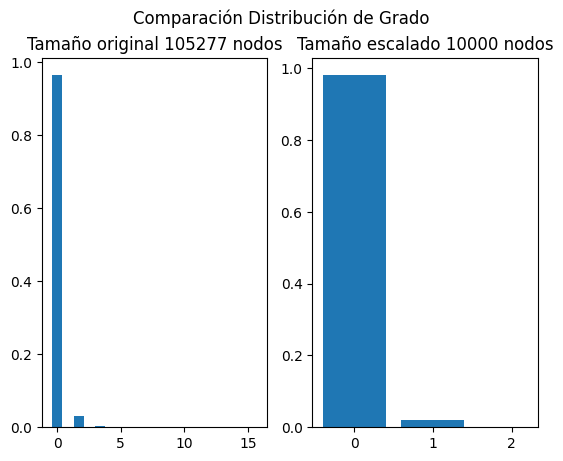

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Comparación Distribución de Grado")

prob_a, bins_a = np.histogram(A_original)
prob_a = prob_a/len(A_original)
ax1.set_title(f"Tamaño original {sum(sizes_original)} nodos")
ax1.bar(bins_a[:-1], prob_a)

prob_b, bins_b = np.histogram(A_esc)
prob_b = prob_b/len(A_esc)
ax2.set_title(f"Tamaño escalado {sum(esc)} nodos")
ax2.bar(bins_b[:-1], prob_b)

In [230]:
sbm_aux_original = nx.adjacency_matrix(sbm_original)
sbm_aux_esc = nx.adjacency_matrix(sbm_esc)

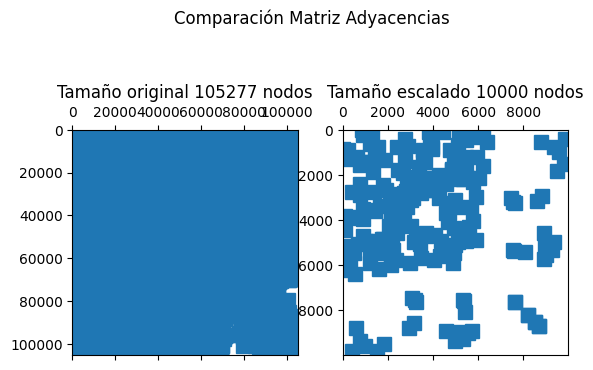

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Comparación Matriz Adyacencias")

ax1.set_title(f"Tamaño original {sum(sizes_original)} nodos")
ax1.spy(sbm_aux_original)

ax2.set_title(f"Tamaño escalado {sum(esc)} nodos")
ax2.spy(sbm_aux_esc)

In [232]:
print(f"Densidad en red original: {nx.density(sbm_original)}")
print(f"Densidad en red escalada: {nx.density(sbm_esc)}")

Densidad en red original: 2.3653943345881604e-06
Densidad en red escalada: 1.9801980198019803e-06


In [233]:
print(f"Average Clustering en red original: {nx.average_clustering(sbm_original)}")
print(f"Average Clustering en red escalada: {nx.average_clustering(sbm_esc)}")

Average Clustering en red original: 0.00011783938934945042
Average Clustering en red escalada: 0.0


Posteriormente se escribe en formato GraphML

In [234]:
aux_columns = ["home_ageb", "cardinalidad"]
ageb_tags_pre = spark.createDataFrame(zipped, aux_columns)

In [235]:
ageb_tags = ageb_tags_pre.orderBy(col("home_ageb").asc()) \
    .withColumn("tags", F.array_repeat(col("home_ageb"), col("cardinalidad").cast(IntegerType()))) \
    .withColumn("final_tags", F.explode("tags")) \
    .select("final_tags")

ageb_tags_pdf = ageb_tags.toPandas()
tags_final = list(ageb_tags_pdf["final_tags"])

In [236]:
assert len(tags_final) == sum(esc)

In [237]:
### Reescribir el grafo
## Reemplazar 'g1' por el nombre del modelo

n=len(list(sbm.nodes())) ##lista con los todos los nodos del modelo generado
enlaces=list(sbm.edges())
bloque= nx.get_node_attributes(sbm, "block") ##diccionario con keys:nombre nodo, value: bloque al que pertenece el nodo
bloque= list(bloque.values()) ## lista con solo los values

##nuevo diccionario
test_keys=list(sbm.nodes())
nuevo_diccionario =  {test_keys[i]: tags_final[i] for i in range(len(test_keys))}

##Con la info de arriba se hace el nuevo grafo que ya puede escribirse en graphml
g2=nx.empty_graph(n) ##le pongo los mismos nodos
g2.add_edges_from(enlaces) ##le pongo los mismos enlaces
nx.set_node_attributes(g2, nuevo_diccionario, "block") ##le agrego un atributo (bloque) a cada nodo

##Escribo el graphml
nx.write_graphml(g2,'./graficas/2020/03032020/03032020.graphml')